In [ ]:
import os
import shutil
import zipfile
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping

# --- 1. CONFIGURATION AND SETUP ---

# Constants
IMG_SIZE = 150
BATCH_SIZE = 32
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
SEED = 42

# Define paths
drive_root = '/content/drive/MyDrive/'
zip_filename = 'catsanddogs.zip'
zip_path = os.path.join(drive_root, zip_filename)
extracted_dir = '/content/catsanddogs_data/'

# --- 2. MOUNT GOOGLE DRIVE & UNZIP DATA ---

# --- MOUNT GOOGLE DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# Clean up previous extraction and create new directory
shutil.rmtree(extracted_dir, ignore_errors=True)
os.makedirs(extracted_dir, exist_ok=True)

# Unzip the data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extracted_dir)

# --- 3. LOCATE THE SOURCE DIRECTORY ---
def find_data_root(start_path):
    for root, dirs, files in os.walk(start_path):
        if 'Cat' in dirs and 'Dog' in dirs:
            return root
    return None

source_dir = find_data_root(extracted_dir)

# Define target data directory structure
base_dir = '/tmp/cats_and_dogs_filtered'
shutil.rmtree(base_dir, ignore_errors=True)
os.makedirs(base_dir, exist_ok=True)

# --- 4. DATA CLEANUP AND ORGANIZATION ---

# Remove known corrupt files
corrupt_files = [
    os.path.join(source_dir, 'Cat/666.jpg'),
    os.path.join(source_dir, 'Dog/11702.jpg')
]
for f in corrupt_files:
    if os.path.exists(f):
        os.remove(f)

def split_data(source, training, validation, testing, split_ratio):
    files = [f for f in os.listdir(source) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.seed(SEED)
    random.shuffle(files)
    train_size = int(len(files) * split_ratio[0])
    val_size = int(len(files) * split_ratio[1])

    for i, filename in enumerate(files):
        src_path = os.path.join(source, filename)
        if i < train_size:
            dst_path = os.path.join(training, filename)
        elif i < train_size + val_size:
            dst_path = os.path.join(validation, filename)
        else:
            dst_path = os.path.join(testing, filename)
        shutil.copyfile(src_path, dst_path)

# Setup directories
for split in ['train', 'validation', 'test']:
    for class_name in ['cats', 'dogs']:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

# Perform split
split_data(os.path.join(source_dir, 'Cat'), os.path.join(base_dir, 'train', 'cats'), os.path.join(base_dir, 'validation', 'cats'), os.path.join(base_dir, 'test', 'cats'), [TRAIN_RATIO, VAL_RATIO, TEST_RATIO])
split_data(os.path.join(source_dir, 'Dog'), os.path.join(base_dir, 'train', 'dogs'), os.path.join(base_dir, 'validation', 'dogs'), os.path.join(base_dir, 'test', 'dogs'), [TRAIN_RATIO, VAL_RATIO, TEST_RATIO])

# --- 5. DATA GENERATORS & AUGMENTATION ---

# Increased augmentation parameters for better generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'), target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary'
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'validation'), target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'), target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

# --- 6. BUILD CNN MODEL ---

model = Sequential([
    # First Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    # Second Block
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    # Third Block
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    # Fourth Block
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    # Classification Head
    Dropout(0.5), # Strong Regularization
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid') # Output
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- 7. COMPILE AND TRAIN WITH EARLY STOPPING ---

# Define the Early Stopping callback (critical for preventing overfitting)
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to watch
    patience=8,                 # Stop after 8 epochs without improvement on val_loss
    restore_best_weights=True   # Keep the model weights from the best epoch
)

# Set high epochs and let Early Stopping determine the actual number
EPOCHS = 50

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping]
)

# --- 8. EVALUATE AND SAVE ---

loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Save the improved model with a new version number
model_save_path_v4 = os.path.join(drive_root, 'cats_vs_dogs_classifier_v4.h5')
model.save(model_save_path_v4)
print(f"\nImproved Model saved to Google Drive at: {model_save_path_v4}")

Mounted at /content/drive
Found 19967 images belonging to 2 classes.
Found 2495 images belonging to 2 classes.
Found 2497 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,811,969 (25.99 MB)

 Trainable params: 6,811,969 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
530/623 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.5266 - loss: 0.6999

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


623/623 ━━━━━━━━━━━━━━━━━━━━ 134s 204ms/step - accuracy: 0.5279 - loss: 0.6984 - val_accuracy: 0.5779 - val_loss: 0.6836
Epoch 2/50
  1/623 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5000 - loss: 0.6817

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5000 - loss: 0.6817 - val_accuracy: 0.5962 - val_loss: 0.6840
Epoch 3/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 122s 196ms/step - accuracy: 0.5569 - loss: 0.6823 - val_accuracy: 0.6278 - val_loss: 0.6410
Epoch 4/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7188 - loss: 0.6026 - val_accuracy: 0.6246 - val_loss: 0.6408
Epoch 5/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 123s 198ms/step - accuracy: 0.6141 - loss: 0.6549 - val_accuracy: 0.6526 - val_loss: 0.6212
Epoch 6/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7188 - loss: 0.6651 - val_accuracy: 0.6461 - val_loss: 0.6213
Epoch 7/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 124s 198ms/step - accuracy: 0.6636 - loss: 0.6173 - val_accuracy: 0.6903 - val_loss: 0.5909
Epoch 8/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5938 - loss: 0.6941 - val_accuracy: 0.6920 - val_loss: 0.5918
Epoch 9/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 125s 201ms/step - accuracy: 0.6813 - loss: 0.5954 - val_accurac

Test Loss: 0.2669
Test Accuracy: 89.26%

Improved Model saved to Google Drive at: /content/drive/MyDrive/cats_vs_dogs_classifier_v4.h5


Model loaded successfully.
Found 2497 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step


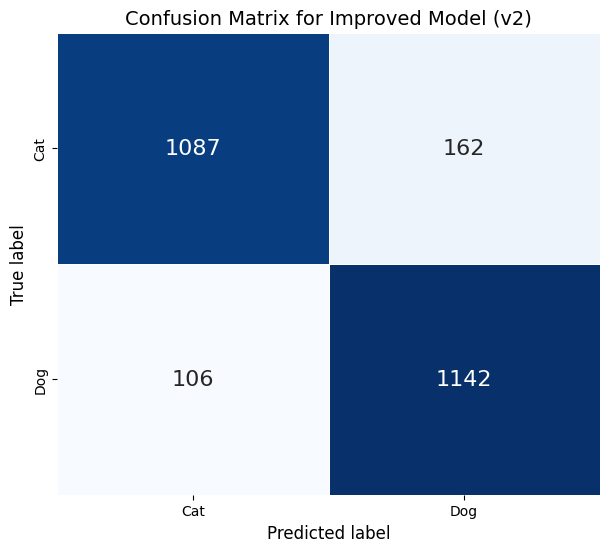


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

         Cat       0.91      0.87      0.89      1249
         Dog       0.88      0.92      0.89      1248

    accuracy                           0.89      2497
   macro avg       0.89      0.89      0.89      2497
weighted avg       0.89      0.89      0.89      2497



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. CONFIGURATION ---

drive_root = '/content/drive/MyDrive/'
model_save_path = os.path.join(drive_root, 'cats_vs_dogs_classifier_v4.h5')
IMG_SIZE = 150
BATCH_SIZE = 32

# Path to the test data organized in the previous steps
base_dir = '/tmp/cats_and_dogs_filtered'
test_data_dir = os.path.join(base_dir, 'test')


# --- 2. LOAD MODEL ---
model = tf.keras.models.load_model(model_save_path)
print("Model loaded successfully.")

# --- 3. CREATE TEST GENERATOR ---

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False # Ensures predictions match true labels
)

# --- 4. MAKE PREDICTIONS ---

# Get the true labels
y_true = test_generator.classes

# Generate predictions (raw probabilities of Dog - Class 1)
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)

# Convert probabilities to class labels (0 or 1) using the 0.5 threshold
y_pred_classes = (y_pred_proba > 0.5).astype(int)

# Truncate predictions to match the number of true labels exactly
if y_pred_classes.shape[0] > y_true.shape[0]:
    y_pred_classes = y_pred_classes[:y_true.shape[0]]

# --- 5. CALCULATE AND PLOT CONFUSION MATRIX ---

# The class indices are used to get the order: Cat (0) and Dog (1)
display_labels = ['Cat', 'Dog']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=display_labels, yticklabels=display_labels,
            linewidths=.5, cbar=False, annot_kws={"size": 16})

plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.title('Confusion Matrix for Improved Model (v2)', fontsize=14)
plt.show()

# --- 6. DISPLAY CLASSIFICATION REPORT ---
print("\n--- CLASSIFICATION REPORT ---")
report = classification_report(y_true, y_pred_classes, target_names=display_labels)
print(report)

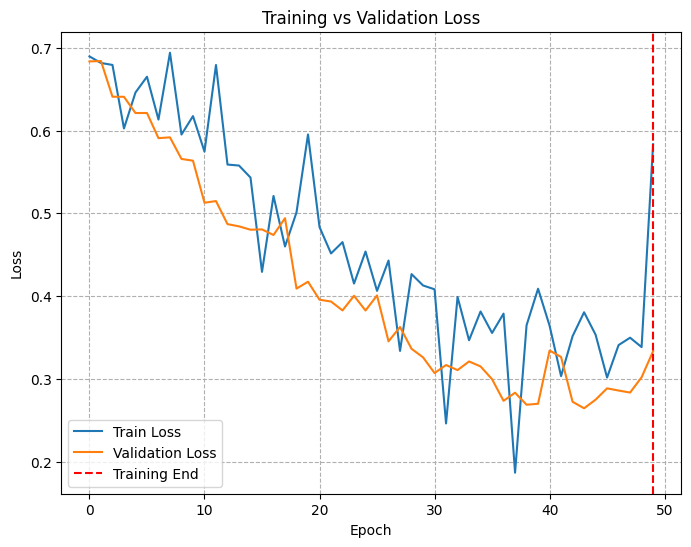

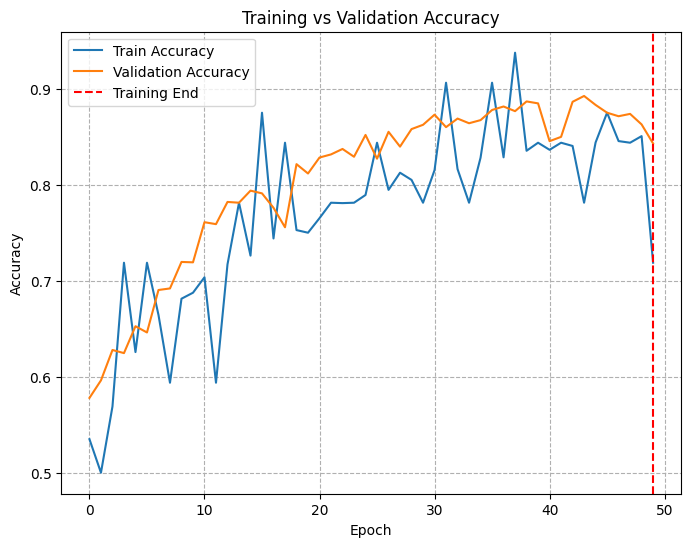

In [ ]:
import matplotlib.pyplot as plt
import os

# --- 1. Training vs Validation Loss Plot ---
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

last_epoch = len(history.history["loss"])
plt.axvline(x=last_epoch - 1, color='r', linestyle='--', label='Training End')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, linestyle='--')
plt.show()


# --- 2. Training vs Validation Accuracy Plot ---
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")

plt.axvline(x=last_epoch - 1, color='r', linestyle='--', label='Training End')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

✅ Model 'cats_vs_dogs_classifier_v4.h5' loaded successfully.
Select one or more dog or cat images to classify:


Saving pic1.jpg to pic1 (1).jpg
Saving pic2.jpg to pic2 (1).jpg
Saving pic3.jpg to pic3 (1).jpg
Saving pic4.jpg to pic4 (1).jpg
Saving pic5.jpg to pic5 (1).jpg
Saving pic6.jpg to pic6 (1).jpg


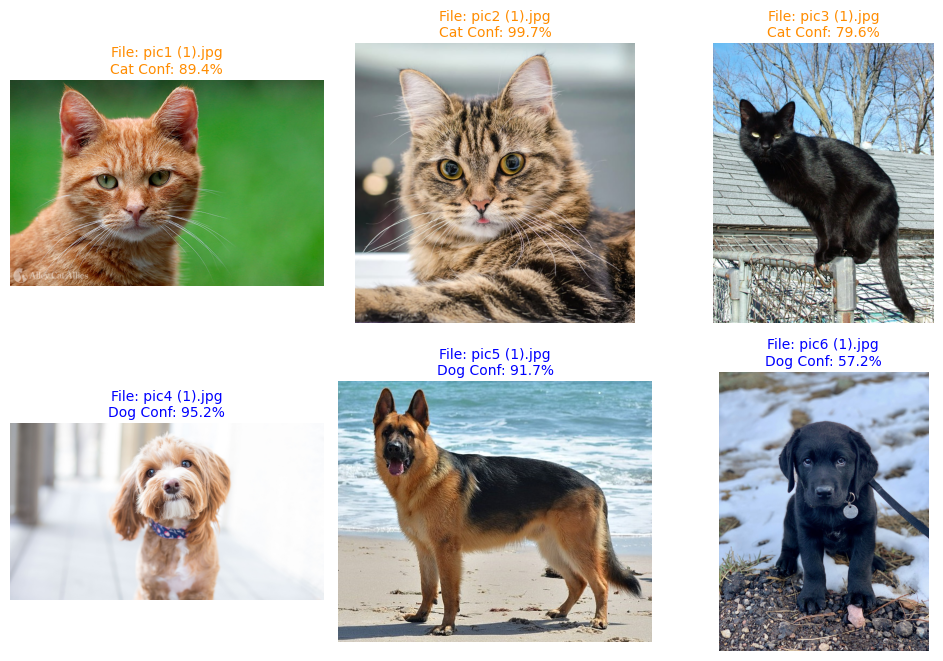

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import os
from google.colab import files

# --- 1. CONFIGURATION ---

# 🚨 IMPORTANT: Use the path to your best-performing model
drive_root = '/content/drive/MyDrive/'
model_save_path = os.path.join(drive_root, 'cats_vs_dogs_classifier_v4.h5')
IMG_SIZE = (150, 150)
DECISION_THRESHOLD = 0.5
class_names = ["Cat", "Dog"]

# --- 2. LOAD MODEL ---

model = tf.keras.models.load_model(model_save_path)
print(f"✅ Model '{os.path.basename(model_save_path)}' loaded successfully.")

# --- 3. PREPROCESSING FUNCTION ---

def preprocess_pil(img_pil, target_size):
    """Resizes, converts to array, normalizes, and adds batch dimension."""
    # Convert to RGB (in case of grayscale) and resize
    img_pil = img_pil.convert("RGB").resize(target_size, Image.BILINEAR)

    # Convert to array and normalize (0 to 1)
    arr = tf.keras.utils.img_to_array(img_pil) / 255.0

    # Add batch dimension [1, H, W, C]
    return np.expand_dims(arr, axis=0)

# --- 4. UPLOAD, PREDICT, AND VISUALIZE ---

print("Select one or more dog or cat images to classify:")
try:
    uploaded = files.upload()
except Exception as e:
    print(f"File upload failed: {e}")
    exit()

imgs, preds, probs = [], [], []
names = list(uploaded.keys())

for name in names:
    img_bytes = uploaded[name]

    # Open image from bytes using PIL
    img = Image.open(io.BytesIO(img_bytes))

    # Preprocess the image
    x = preprocess_pil(img, IMG_SIZE)

    # Predict (raw probability of Dog: P(Dog))
    p = float(model.predict(x, verbose=0).ravel()[0])

    # Determine the predicted class (0 for Cat, 1 for Dog)
    yhat = int(p >= DECISION_THRESHOLD)

    # Store results
    imgs.append(img)
    preds.append(yhat)
    probs.append(p)

# --- 5. VISUALIZE RESULTS ---

# Visualize up to 9 images in a 3x3 grid
n = min(9, len(imgs))
plt.figure(figsize=(10, 10))
for i in range(n):
    ax = plt.subplot(3, 3, i + 1)

    # Display image
    plt.imshow(imgs[i])

    # Get prediction details
    pred_name = class_names[preds[i]]
    # Calculate confidence for the predicted class
    conf = probs[i] if preds[i] == 1 else (1.0 - probs[i])

    # Set title color based on prediction
    color = 'blue' if preds[i] == 1 else 'darkorange'

    ax.set_title(f"File: {names[i]}\n{pred_name} Conf: {conf*100:.1f}%",
                 fontsize=10, color=color, pad=5)
    ax.axis("off")

plt.tight_layout()
plt.show()